# Тема: Коллаборативная фильтрация

## Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации.  
* Чем они отличаются и чем они похожи?
    * отличие - Item-Item - товар оценен пользователем, примерно также как похожий товар оценен этим же пользователем; User-User - пользователь оценит товар примерно также, как похожий на него пользователь.
    * похожесть - сложность алгоритмов.
* Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec?   
    * можно, только необходимо транспонировать матрицу. 
* В чем принципиальные отличия item-item рекомендаций от ALS?
    * ALS формирет рекомендации в том числе для новых юзеров, item-item нет.
    * скорость обработки данных

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 
* популярные за последние 10 дней
* популярные по времени суток
* полуярные по ид магазина

3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)
* ограничения по количеству обрабатываемых параметров
* алгоритм работает только на данных уже продаваемых товаров, невозможно заранее учесть сезонность товара

4. Мы рассматривали bm_25_weight. Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?
    * информацию по этой теме не нашла

## Практическая часть


In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Для работы с матрицами
from scipy.sparse import csr_matrix

from time import time

import warnings
warnings.simplefilter('ignore')

In [44]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]

    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)

    return precision

In [46]:
data = pd.read_csv('data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id', 'product_id': 'item_id'},inplace=True)

test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [47]:
result_train = data_train.groupby('user_id')['item_id'].unique().reset_index()
result_train.columns=['user_id', 'actual']
result_train.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [48]:
result_test = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [49]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [50]:
def get_matrix(values):

    # матрица весов
    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values=values, 
                                      aggfunc= 'count', 
                                      fill_value=0)

    user_item_matrix = user_item_matrix.astype(float)

    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    userids = user_item_matrix.index.values
    itemids = user_item_matrix.columns.values

    matrix_userids = np.arange(len(userids))
    matrix_itemids = np.arange(len(itemids))

    id_to_itemid = dict(zip(matrix_itemids, itemids))
    id_to_userid = dict(zip(matrix_userids, userids))

    itemid_to_id = dict(zip(itemids, matrix_itemids))
    userid_to_id = dict(zip(userids, matrix_userids))

    return user_item_matrix, userid_to_id, id_to_itemid, itemid_to_id, sparse_user_item

In [64]:
def get_model(user_item_matrix, factors, regularization):
        
    model = AlternatingLeastSquares(factors=factors,
                                        regularization=regularization,
                                        iterations=15, 
                                        calculate_training_loss=True, 
                                        num_threads=4)

    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
    
    return model

In [65]:
def get_recommendations(user, model, user_item_matrix, userid_to_id, id_to_itemid, itemid_to_id, sparse_user_item):
    
    recs = model.recommend(userid=userid_to_id[user],
                                user_items=sparse_user_item, 
                                N=5,
                                filter_already_liked_items=False, 
                                filter_items=[itemid_to_id[999999]],#None, 
                                recalculate_user=True)

    res = [id_to_itemid[rec[0]] for rec in recs]

    return res

In [66]:
%%time
       
stata_v = pd.DataFrame(columns=['values', 'result_train', 'result_test'])

values = ['quantity', 'day', 'trans_time', 'store_id']

for i, v in enumerate(values):
    
    ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui = get_matrix(v)
    model_als = get_model(ui_matrix, factors=100, regularization=0.001)

    result_train['als_'+v] = result_train['user_id'].apply(lambda x: \
                            get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
    r_train = result_train.apply(lambda row: precision_at_k(row['als_'+v], row['actual']), axis=1).mean()
    
    result_test['als_'+v] = result_test['user_id'].apply(lambda x: \
                            get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
    r_test= result_test.apply(lambda row: precision_at_k(row['als_'+v], row['actual']), axis=1).mean()

    stata_v.loc[i] = [v, r_train, r_test]
    
stata_v


CPU times: user 4min 35s, sys: 739 ms, total: 4min 36s
Wall time: 2min 29s


,values,result_train,result_test
0,quantity,0.829772,0.178452
1,day,0.828411,0.180215
2,trans_time,0.827611,0.179726
3,store_id,0.826331,0.181881


**Вывод:**
* без предварительной обработки данных использование разных матриц весов не даёт существенного прироста результата.

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.GridSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [59]:
factors=[50, 100, 150]
regularization = [0.1, 0.01, 0.001]

v = 'day'
ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui = get_matrix(v)

stata_g = pd.DataFrame(columns=['factor', 'regular', 'time', 'result_train', 'result_test'])

for i in factors:
    for j in regularization:
        time_start = time()
        model_als = get_model(ui_matrix, factors=i, regularization=j)
        time_finish = time() - time_start
        
        result_train[f'als_f_{i}_r_{j}'] = result_train['user_id'].apply(lambda x: \
                                get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
        r_train = result_train.apply(lambda row: precision_at_k(row[f'als_f_{i}_r_{j}'], row['actual']), axis=1).mean()
        
        result_test[f'als_f_{i}_r_{j}'] = result_test['user_id'].apply(lambda x: \
                                get_recommendations(x, model_als, ui_matrix, u_to_id, id_to_i, i_to_id, sparse_ui))
        r_test= result_test.apply(lambda row: precision_at_k(row[f'als_f_{i}_r_{j}'], row['actual']), axis=1).mean()

        stata_g.loc[f'{i}_{j}'] = [i, j, time_finish, r_train, r_test]
        
stata_g

,factor,regular,time,result_train,result_test
50_0.1,50.0,0.100,8.915705,0.715086,0.188051
50_0.01,50.0,0.010,8.883357,0.716687,0.187463
50_0.001,50.0,0.001,8.892382,0.715486,0.185211
100_0.1,100.0,0.100,8.971442,0.801761,0.181391
100_0.01,100.0,0.010,8.998308,0.822329,0.185994
100_0.001,100.0,0.001,8.939713,0.833934,0.180020
150_0.1,150.0,0.100,9.198372,0.888435,0.169736
150_0.01,150.0,0.010,9.157155,0.886995,0.172086
150_0.001,150.0,0.001,9.046821,0.888756,0.164349


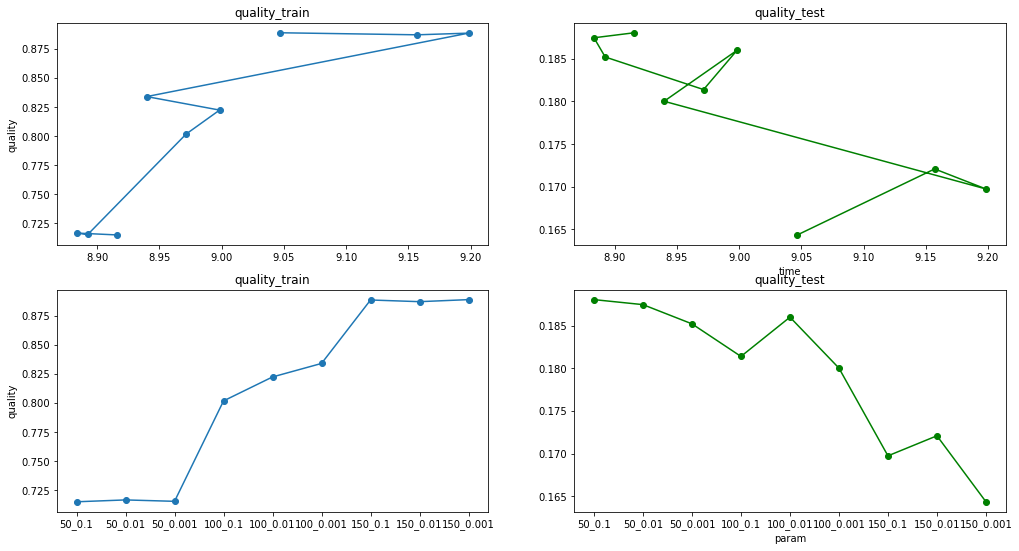

In [67]:
x1 = np.array(stata_g['time'])
x2 = np.array(stata_g.index)

y1 = np.array(stata_g['result_train'])
y2 = np.array(stata_g['result_test'])

plt.figure(figsize=(17, 9))

plt.subplot(2, 2, 1)
plt.plot(x1, y1)
plt.scatter(x1, y1)
plt.title('quality_train')
plt.ylabel('quality')

plt.subplot(2, 2, 2)
plt.plot(x1, y2, c='g')
plt.scatter(x1, y2, c='g')
plt.title('quality_test')
plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x2, y1)
plt.scatter(x2, y1)
plt.title('quality_train')
plt.ylabel('quality')

plt.subplot(2, 2, 4)
plt.plot(x2, y2, c='g')
plt.scatter(x2, y2, c='g')
plt.title('quality_test')
plt.xlabel('param')

plt.show()

**Вывод:**
* чем больше времени занимает обучение модели, тем выше качетво прогнозирования на train, но при этом падает качество прогнозирования на test
* при увеличении гиперпараметра factors и уменьшении regularization качество на train растет, в то время как качество на test падает.
* оптимальные параметры для модели AlternatingLeastSquares на текущих данных:
    * factors=100
    * regularization=0.01